| Method                 | Order | A-stable? | Symmetric? | Symplectic? | Algebraic stability? | Key Features |
|------------------------|-------|-----------|------------|-------------|-----------------------|--------------|
| Explicit Euler         | 1     | ❌ No      | ❌ No       | ❌ No        | ❌ No                 | Simplest explicit method |
| Classical RK4          | 4     | ❌ No      | ❌ No       | ❌ No        | ❌ No                 | High accuracy but not A-stable |
| Implicit Midpoint      | 2     | ✅ Yes     | ✅ Yes      | ✅ Yes       | ✅ Yes                | Good for stiff and Hamiltonian systems |
| 3-stage Gauss–Legendre | 6     | ✅ Yes     | ✅ Yes      | ✅ Yes       | ✅ Yes                | Implicit RK from Gauss–Legendre collocation; 3 stages achieve 6th order |


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import math

In [11]:
plt.rcParams.update({
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'font.size': 14
})


## The Duffing equation:
### Formula:
$
\ddot{x} + \gamma \dot{x} + \alpha x + \beta x^3 = \delta \cos(\omega t)
$  
  
Convert to first-order system with $x_1 = x$, $x_2 = \dot{x}$:  
  
$
\dot{x}_1 = x_2,\quad
\dot{x}_2 = -\gamma x_2 - \alpha x_1 - \beta x_1^3 + \delta \cos(\omega t)
$

### Aim:
Give the initial condition and parameters, our aim is to motivate the evolution of displacement & velocity.

In [2]:
def f(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        time: float = 0.1):
        
    # return the 1-order derivative of x1 and x2
    x1_prime = x20
    x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)

    return x1_prime, x2_prime

  
## Euler's method

Euler update at each step $n \to n+1$ with step size $dt$:  
  
$
x_{1, n+1} = x_{1, n} + dt \cdot x_{2, n}
$    
  
$
x_{2, n+1} = x_{2, n} + dt \cdot \left(-\gamma x_{2, n} - \alpha x_{1, n} - \beta (x_{1, n})^3 + \delta \cos(\omega t_{n})\right)
$  

In [3]:
def Euler(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1):
    
    x1_prime, x2_prime = f(x10, x20, alpha, beta, gamma, delta, omega, time)

    x1 = x10 + h * x1_prime
    x2 = x20 + h * x2_prime
    
    return x1, x2

## Explicit RK4
  
Let the state vector:
  
$\mathbf{X} = \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}$  
  
  
The differential equation:
  
$\dot{\mathbf{X}} = f(t, \mathbf{X})$  
  
  
RK4 updates as：
  
$\mathbf{X}_{n+1} = \mathbf{X}_n + \frac{dt}{6}(k_1 + 2k_2 + 2k_3 + k_4)$
  
  
with 
  
$k_1 = f(t_n, \mathbf{X}_n)$  
  
  
$k_2 = f\Big(t_n + \tfrac{dt}{2}, \mathbf{X}_n + \tfrac{dt}{2}k_1\Big)$
  
  
$k_3 = f\Big(t_n + \tfrac{dt}{2}, \mathbf{X}_n + \tfrac{dt}{2}k_2\Big)$
  
  
$k_4 = f(t_n + dt, \mathbf{X}_n + dt \cdot k_3)$
  


In [4]:
def RK4(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1):
    
    k1_x1, k1_x2 = f(x10, x20, alpha, beta, gamma, delta, omega, time)
    
    k2_x1, k2_x2 = f(
        x10 + 0.5 * h * k1_x1,
        x20 + 0.5 * h * k1_x2,
        alpha, beta, gamma, delta, omega,
        time + h / 2
    )
    
    k3_x1, k3_x2 = f(
        x10 + 0.5 * h * k2_x1,
        x20 + 0.5 * h * k2_x2,
        alpha, beta, gamma, delta, omega,
        time + h / 2
    )
    
    k4_x1, k4_x2 = f(
        x10 + h * k3_x1,
        x20 + h * k3_x2,
        alpha, beta, gamma, delta, omega,
        time + h
    )
    
    x1 = x10 + (h / 6) * (k1_x1 + 2 * k2_x1 + 2 * k3_x1 + k4_x1)
    x2 = x20 + (h / 6) * (k1_x2 + 2 * k2_x2 + 2 * k3_x2 + k4_x2)
    
    return x1, x2

# Implicit midpoint (Gauss–Legendre 1-stage)
formula: $X = X_n + h \, f\!\left(t_n + \tfrac{h}{2}, \tfrac{X_n + X}{2}\right)$  
  
Procedures:

1. Define the residual function, which is our optimization aim  
  
    $  
    G(X) = X - X_n - h\,f\!\Big(t_n+\tfrac{h}{2},\,\tfrac{X_n+X}{2}\Big).
    $  
    
    Our goal is to find a $X$ such that $G(X)=0$.  
    And we use Newton's method to do that (Cause Duffing equation does not have analytical solution, we can only appromation. And Duffing equation is stiff, so functional iteration doesn't work, we need to use Newton's method).
    
2. Newton's Method:
   - At iterate $X^{(k)}$, linearize  
       
     $
     G(X^{(k)}+s) \approx G(X^{(k)}) + J\,s,
     $  
       
     through Taylor's expansion and setting $G(X^{(k)}+s)=0$, where $J=\partial G/\partial X$ is the Jacobian evaluated at $X^{(k)}$.
   - Solve the linear system 
     $
     J\,s = -G(X^{(k)}),
     $
     then update $X^{(k+1)}=X^{(k)}+s$.
   - Repeat until $\|s\|$ small.

3. Jacobian for the Duffing system:
   - For $X=[x_1,x_2]^T$ and  
       
     $
     f(t,X)=\begin{pmatrix} x_2 \\ -\gamma x_2 -\alpha x_1 -\beta x_1^3 + \delta\cos(\omega t)\end{pmatrix},
     $  
       
     the derivative of $f$, written as $D_f$, at the midpoint $X_{\mathrm{mid}}=(X_n+X)/2$ is  
       
     $
     D_f=\begin{pmatrix}0 & 1\\[4pt] -(\alpha+3\beta x_{1,\mathrm{mid}}^2) & -\gamma \end{pmatrix}.
     $
       
   - Then
     $$
     J = dG/dX = I − h · (dX_{\mathrm{mid}}/dX) · (∂f/∂X_{\mathrm{mid}} at X_{\mathrm{mid}}) = I - \frac{h}{2} D_f
     =
     \begin{pmatrix}
     1 & -\tfrac{h}{2}\\[6pt]
     \tfrac{h}{2}(\alpha+3\beta x_{1,\mathrm{mid}}^2) & 1+\tfrac{h}{2}\gamma
     \end{pmatrix}.
     $$  
     Use it to iterate through Newton's method.

In [5]:
def midpoint(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1,
        max_iteration: int = 30,
        tol: float = 1e-9
        ):
    
    # To start Newton's method, we first set a initial value to X (our aim) for iteration
    # Set the initial value by explicit Euler's method
    x1, x2 = Euler(x10, x20, alpha, beta, gamma, delta, omega, h, time)
    X = np.array([x1, x2], dtype=float)
    X0 = np.array([x10, x20], dtype=float)
    
    for _ in range(max_iteration):
        m = (X + X0) / 2
        G = X - X0 - h * np.array(f(m[0], m[1], alpha, beta, gamma, delta, omega, time + 0.5 * h), dtype=float)
        # the Jacobian of f w.r.t. m
        Df = np.array([[0.0, 1.0],
                       [-(alpha + 3.0 * beta * m[0]**2), -gamma]],
                      dtype=float)
        # the Jacobian of G w.r.t. X
        J = np.eye(2) - 0.5 * h * Df
        
        if np.allclose(J, np.zeros((2, 2))):  # if the Jacobian becomes to zero
            return X[0], X[1]

        # catch LinAlgError
        try:
            s = np.linalg.solve(J, -G)
        except np.linalg.LinAlgError:
            lin_alg_error = True
            print("MidPoint: lin_alg_error occurs")
            raise 

        # catch diverge
        if (not np.isfinite(s).all()) or np.linalg.norm(s) > 1e6:
            diverged = True
            print("GL3: diverged")

        X = X + s

        if np.linalg.norm(s, ord=2) < tol or np.linalg.norm(G, ord=2) < tol:
            break

    return X[0], X[1]

# 3-Stage Gauss-Legendre

- Similar idea to **Implicit Midpoint**. Our aim is to construct the residual function $G$, and utilize $J s = -G$ to iterate.
- The difference is that, we now have 3 stages (time nodes) between $[time, time + h]$. Therefore, we need to give all three of them initial values, and RK4 is adopted here. Moreover, when contructing $G$, it should be the function of all three stages.
### Details:
1. In 3-stage GL, every stage satisfies that:  
      
    $X_i = y_n + h \sum_{j=1}^3 A_{ij}\, f(t_n+c_j h, X_j), \quad i=1,2,3.$  
      
2. The residual function is:  
      
    $G_i(X) := X_i - y_n - h \sum_{j=1}^3 A_{ij}\, f(t_n+c_j h, X_j).$  with $G=(G_1,G_2,G_3)$, and $G_i\in\mathbb{R}^2$
      
    Our aim is find the solution to make it to be zero.

3. The partial derivate of $G$ w.r.t. $X_j$, $j=1,2,3$, is 
      
    $\frac{\partial G_i}{\partial X_j} = \delta_{ij} I_2 - h A_{ij} f_y(t_j,X_j)$   
      
    with $\delta_{ij}$ the Kronecker delta, $\delta_{ij} =\begin{cases} 1, & i=j,\\0, & i\neq j.\end{cases}$

4. Thus, the Jacobian of $G$ is:
      
      $$J = 
        \begin{bmatrix}
        I_2 - h A_{11} f(X_1) & -h A_{12} f(X_2) & -h A_{13} f(X_3) \\
        -h A_{21} f(X_1) & I_2 - h A_{22} f(X_2) & -h A_{23} f(X_3) \\
        -h A_{31} f(X_1) & -h A_{32} f(X_2) & I_2 - h A_{33} f(X_3)
        \end{bmatrix}.
      $$


In [6]:
def GL3stage(
        x10: float = 1, 
        x20: float = 0, 
        alpha: float = -1.0, 
        beta: float = 1, 
        gamma: float = 0.02, 
        delta: float = 3, 
        omega: float = 1, 
        h: float = 0.1,
        time: float = 0.1,
        max_iteration: int = 100,
        tol: float = 1e-9
        ):

    sqrt15 = np.sqrt(15.0)
    A = np.array([
        [5/36, 2/9 - sqrt15/15, 5/36 - sqrt15/30],
        [5/36 + sqrt15/24, 2/9, 5/36 - sqrt15/24],
        [5/36 + sqrt15/30, 2/9 + sqrt15/15, 5/36]
    ], dtype=float)  # based on the Butcher Tableau
    b = np.array([5/18, 4/9, 5/18])
    c = np.array([1/2 - sqrt15/10, 1/2, 1/2 + sqrt15/10])

    # 
    def Df(x1):
        return np.array([[0.0, 1.0],
                [-(alpha + 3.0 * beta * x1**2), -gamma]],
                dtype=float)

    X0 = np.array([x10, x20])
    X = np.zeros((3, 2))

    # use RK4 to assign initial values for X
    for i in range(3):
        X[i] = RK4(x10, x20, alpha, beta, gamma, delta, omega, c[i]*h, time)
    
    for _ in range(max_iteration):

        # calculate J
        f_block = np.zeros((3, 2), dtype=float)
        for j in range(3):
            f_block[j] = np.array(
                f(X[j, 0], X[j, 1], alpha, beta, gamma, delta, omega, time + c[j] * h),
                dtype=float
            )
        J = np.zeros((6, 6), dtype=float)
        I2 = np.eye(2)
        for i in range(3):
            for j in range(3):
                Df_j = Df(X[j, 0])
                block = (I2 if i == j else np.zeros((2, 2))) - h * A[i, j] * Df_j
                J[2*i:2*i+2, 2*j:2*j+2] = block

        # Calculate G
        G = np.zeros((3, 2), dtype=float)
        for i in range(3):
            s = np.zeros(2, dtype=float)
            for j in range(3):
                s += A[i, j] * f_block[j]
            G[i] = X[i] - X0 - h * s
        
        G_vec = G.ravel()  # 3 × 2 -> 6
        try:
            s_vec = np.linalg.solve(J, -G_vec)
        except np.linalg.LinAlgError:
            raise RuntimeError("GL3stage: Jacobian singular")

        X_flat = X.ravel() + s_vec
        X = X_flat.reshape(3, 2)

        if np.linalg.norm(s_vec, ord=2) < tol or np.linalg.norm(G_vec, ord=2) < tol:
            break
    
    # calculate the final result
    sum_bf = np.zeros(2, dtype=float)
    for j in range(3):
        fj = np.array(
            f(X[j, 0], X[j, 1], alpha, beta, gamma, delta, omega, time + c[j] * h),
            dtype=float
        )
        sum_bf += b[j] * fj
    X_next = X0 + h * sum_bf

    return X_next[0], X_next[1]

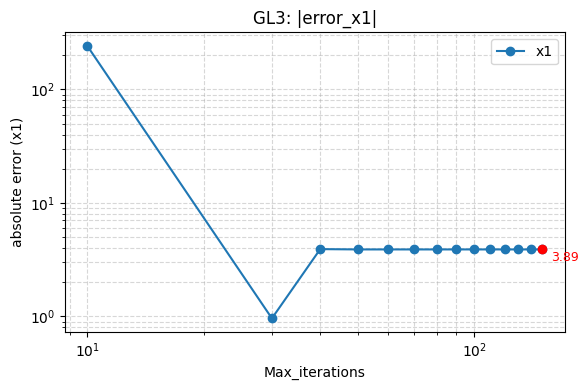

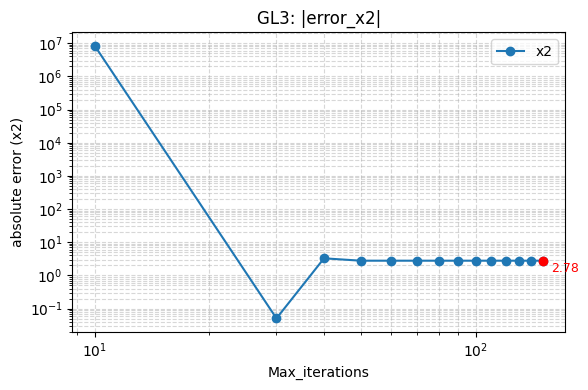

In [7]:
ref = np.array([1.86896745, 1.83346824])
h = 10
x10, x20 = 0.7, 0.2
# x10, x20 = 1.0, 0.0
# alpha, beta, gamma, delta, omega = -1.0, 1.0, 0.02, 3, 1.0
alpha, beta, gamma, delta, omega = -1.0, 1.0, 0, 0, 1.0
time = 0.0
x1, x2 = x10, x20

errors = {"x1": [], "x2": []}
max_iters = [10, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
for max_iter in max_iters:
    for _ in range(int(20/h)):
        x1, x2 = GL3stage(x10, x20, alpha, beta, gamma, delta, omega, h, time, max_iteration=max_iter)
    
    abs_err = np.abs(np.array([x1, x2]) - ref)
    errors["x1"].append(float(abs_err[0]))
    errors["x2"].append(float(abs_err[1]))


plt.figure(figsize=(6,4))
plt.loglog(max_iters, errors["x1"], '-o', label=f"x1")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlabel('Max_iterations'); plt.ylabel('absolute error (x1)'); plt.legend(); plt.title('GL3: |error_x1|')
x_last = float(max_iters[-1])
y_last = float(errors["x1"][-1])
plt.scatter([x_last], [y_last], color='red', zorder=10)
plt.annotate(f"{y_last:.3g}", xy=(x_last, y_last),
                xytext=(6, -8), textcoords='offset points', color='red', fontsize=9)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.loglog(max_iters, errors["x2"], '-o', label=f"x2")
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlabel('Max_iterations'); plt.ylabel('absolute error (x2)'); plt.legend(); plt.title('GL3: |error_x2|')
x_last = float(max_iters[-1])
y_last = float(errors["x2"][-1])
plt.scatter([x_last], [y_last], color='red', zorder=10)
plt.annotate(f"{y_last:.3g}", xy=(x_last, y_last),
                xytext=(6, -8), textcoords='offset points', color='red', fontsize=9)
plt.tight_layout()
plt.show()

In [17]:
x10, x20 = 0.7, 0.2
# x10, x20 = 1.0, 0.0
# alpha, beta, gamma, delta, omega = -1.0, 1.0, 0.02, 3, 1.0
alpha, beta, gamma, delta, omega = -1.0, 1.0, 0, 0, 1.0
h = 0.01
time = 0.0  # t_n

In [ ]:
# convergence analysis
def integrate_method(method, x0, t0, h, n_steps, **params):
    x1, x2 = x0
    t = t0
    call_params = {k: v for k, v in params.items() if k != 'time'}
    for _ in range(n_steps):
        x1, x2 = method(x1, x2, **call_params, h=h, time=t)
        t += h
    return np.array([x1, x2])

T = 20.0
t0 = 0.0
x0 = (x10, x20)
h_list = (10.0 * 0.5**np.arange(0, 14))[::-1]  # increasing: [~0.0012207, ..., 10], 14 choices
methods = {
    'Euler': Euler,
    'RK4'  : RK4,
    'Midpoint': midpoint,
    'GL3'  : GL3stage
}
params = dict(alpha=alpha, beta=beta, gamma=gamma, delta=delta, omega=omega, time=t0)

h_ref = 1e-4
n_ref = int(T / h_ref)
ref = integrate_method(GL3stage, x0, t0, h_ref, n_ref, **params)
print(f"ref is {ref}")

errors = {name: {"x1": [], "x2": []} for name in methods}
for h in h_list:
    n = int(T / h)
    for name, meth in methods.items():
        sol = integrate_method(meth, x0, t0, h, n, **params)  # sol is array([x1, x2])
        abs_err = np.abs(sol - ref)                          # elementwise absolute error
        errors[name]["x1"].append(float(abs_err[0]))
        errors[name]["x2"].append(float(abs_err[1]))

# print errors and the estimated orders (from log-log fit) separately for x1 and x2
for name in methods:
    hs = np.array(h_list)
    ex1 = np.array(errors[name]["x1"])
    ex2 = np.array(errors[name]["x2"])

    mask1 = np.isfinite(ex1) & (ex1 > 0)
    mask2 = np.isfinite(ex2) & (ex2 > 0)

    if mask1.sum() >= 2:
        p1, _ = np.polyfit(np.log(hs[mask1]), np.log(ex1[mask1]), 1)
        order_x1 = p1
    else:
        order_x1 = float('nan')

    if mask2.sum() >= 2:
        p2, _ = np.polyfit(np.log(hs[mask2]), np.log(ex2[mask2]), 1)
        order_x2 = p2
    else:
        order_x2 = float('nan')

    print(f"{'Step':>4s} | {'x1 error':>12s} | {'x2 error':>12s}")
    print("-" * 36)
    for i, (e1, e2) in enumerate(zip(ex1, ex2)):
        print(f"{i:4d} | {e1:12.6e} | {e2:12.6e}")
    print(f"\nObserved orders: x1 ≈ {order_x1:.3f}, x2 ≈ {order_x2:.3f}")

ref is [0.96467695 0.409441  ]


C:\Windows\Temp\ipykernel_46840\1639351232.py:13: RuntimeWarning: overflow encountered in scalar power
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)
C:\Windows\Temp\ipykernel_46840\1639351232.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)


Step |     x1 error |     x2 error
------------------------------------
   0 | 2.129666e-02 | 4.616913e-03
   1 | 4.421113e-02 | 7.149197e-03
   2 | 9.485853e-02 | 5.106495e-03
   3 | 2.139235e-01 | 3.211325e-02
   4 | 4.881404e-01 | 2.429354e-01
   5 | 3.713323e-01 | 1.027274e+00
   6 | 2.317454e+00 | 1.632719e+00
   7 |          nan |          nan
   8 |          nan |          nan
   9 |          nan |          nan
  10 |          nan |          nan
  11 | 1.277673e+26 | 4.133587e+29
  12 | 3.911476e+04 | 1.007086e+06
  13 | 3.943532e+01 | 1.664694e+02

Observed orders: x1 ≈ 3.343, x2 ≈ 4.117
Step |     x1 error |     x2 error
------------------------------------
   0 | 5.482281e-13 | 1.143530e-13
   1 | 9.969914e-12 | 1.618650e-12
   2 | 1.586881e-10 | 2.626382e-11
   3 | 2.472207e-09 | 4.375482e-10
   4 | 3.737792e-08 | 7.558814e-09
   5 | 5.279377e-07 | 1.387133e-07
   6 | 6.182912e-06 | 2.781186e-06
   7 | 2.581309e-05 | 6.186804e-05
   8 | 1.857821e-03 | 1.493136e-03
   9 | 6.8

In [20]:
import numpy as np

a = np.inf
b = np.inf
c = a - b  # inf - inf = nan
print("inf - inf =", c)

d = np.nan
e = 0.0
f = d * e  # nan * 0 = nan（有些实现可能返回0，但NumPy返回nan）
print("nan * 0 =", f)

g = np.nan
h = 1.0
i = g + h  # nan + 1 = nan
print("nan + 1 =", i)

inf - inf = nan
nan * 0 = nan
nan + 1 = nan


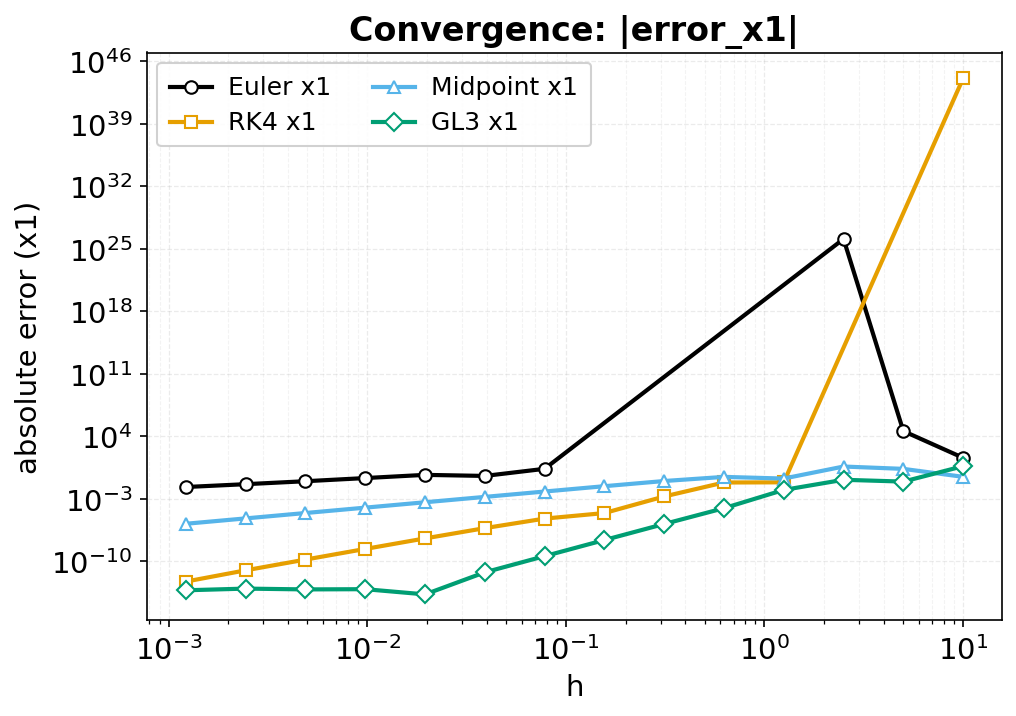

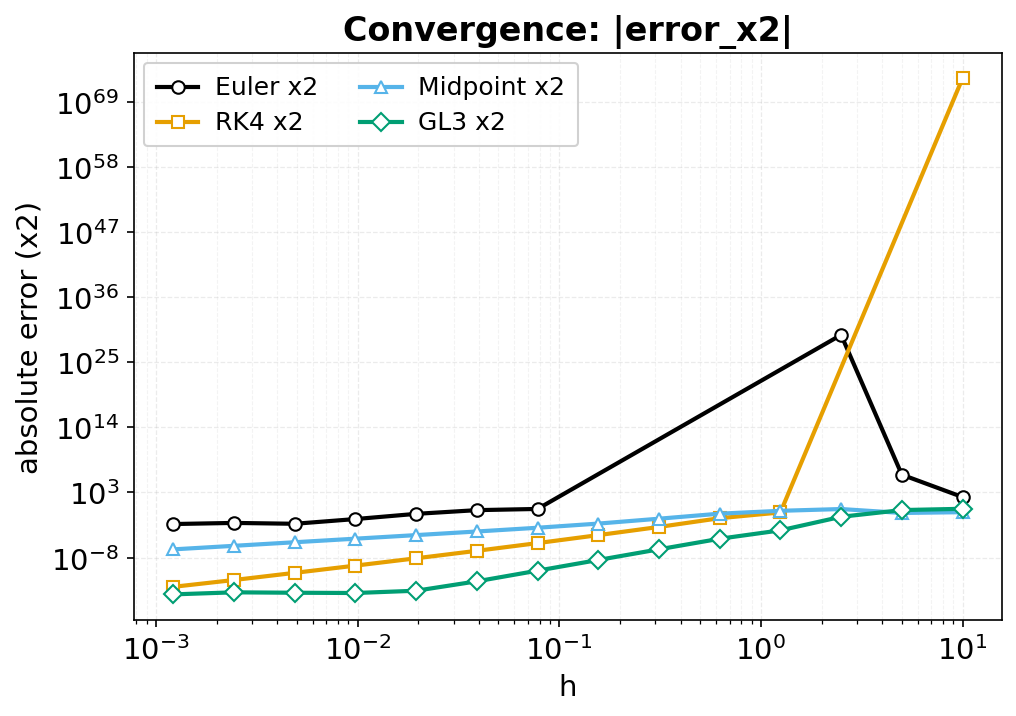

In [ ]:
def _to_1d(a):
    a = np.asarray(a)
    a = np.squeeze(a)
    if a.ndim > 1:
        a = a.ravel()
    return a

def loglog_safe(ax, x, y, *args, **kwargs):
    x1, y1 = _to_1d(x), _to_1d(y)
    if x1.size != y1.size:
        raise ValueError(f"x and y sizes differ: {x1.size} vs {y1.size}")
    m = np.isfinite(x1) & np.isfinite(y1) & (x1 > 0) & (y1 > 0)  # log–log 需要正数
    if not np.any(m):
        raise ValueError("No finite positive points to plot on log–log.")
    return ax.loglog(x1[m], y1[m], *args, **kwargs)

OI = ['#000000', '#E69F00', '#56B4E9', '#009E73', '#D55E00', '#CC79A7', '#F0E442', '#0072B2']
markers = ['o', 's', '^', 'D', 'v', '>', '<', 'P']
linestyles = ['-', '-', '-', '-', (0,(3,1,1,1)), (0,(5,2))]

color_map = {name: OI[i % len(OI)] for i, name in enumerate(methods)}
marker_map = {name: markers[i % len(markers)] for i, name in enumerate(methods)}
ls_map     = {name: linestyles[i % len(linestyles)] for i, name in enumerate(methods)}

common = dict(linewidth=2.0, markersize=6, markerfacecolor='white')

fig1, ax1 = plt.subplots(figsize=(7, 5))
for name in methods:
    lbl = f"{name} x1"
    loglog_safe(ax1, h_list, errors[name]["x1"],
                color=color_map[name], marker=marker_map[name], linestyle=ls_map[name],
                label=lbl, **common)

ax1.grid(True, which='major', alpha=0.25, linestyle='--', linewidth=0.6)
ax1.grid(True, which='minor', alpha=0.15, linestyle='--', linewidth=0.5)
ax1.set_xlabel('h')
ax1.set_ylabel('absolute error (x1)')
ax1.set_title('Convergence: |error_x1|', fontsize=16, fontweight='bold')
leg1 = ax1.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.6, loc='best', ncol=2, fontsize=10)
for t in leg1.get_texts():
    t.set_fontsize(12)
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(7, 5))
for name in methods:
    lbl = f"{name} x2"
    loglog_safe(ax2, h_list, errors[name]["x2"],
                color=color_map[name], marker=marker_map[name], linestyle=ls_map[name],
                label=lbl, **common)

ax2.grid(True, which='major', alpha=0.25, linestyle='--', linewidth=0.6)
ax2.grid(True, which='minor', alpha=0.15, linestyle='--', linewidth=0.5)
ax2.set_xlabel('h')
ax2.set_ylabel('absolute error (x2)')
ax2.set_title('Convergence: |error_x2|', fontsize=16, fontweight='bold')
leg2 = ax2.legend(frameon=True, fancybox=True, framealpha=0.9, borderpad=0.6, loc='best', ncol=2, fontsize=10)
for t in leg2.get_texts():
    t.set_fontsize(12)
plt.tight_layout()
plt.show()


In [128]:
# Single-step comparison
e_x1, e_x2 = Euler(x10, x20, alpha, beta, gamma, delta, omega, h, time)
rk_x1, rk_x2 = RK4(x10, x20, alpha, beta, gamma, delta, omega, h, time)
mp_x1, mp_x2 = midpoint(x10, x20, alpha, beta, gamma, delta, omega, h, time)
gl_x1, gl_x2 = GL3stage(x10, x20, alpha, beta, gamma, delta, omega, h, time)

print(f"After one step (h={h}) from t={time}")
print(f"Euler      : x1={e_x1:.12g}, x2={e_x2:.12g}")
print(f"RK4        : x1={rk_x1:.12g}, x2={rk_x2:.12g}")
print(f"Midpoint   : x1={mp_x1:.12g}, x2={mp_x2:.12g}")
print(f"Gauss-3    : x1={gl_x1:.12g}, x2={gl_x2:.12g}")

After one step (h=10.0) from t=0.0
Euler      : x1=1, x2=30
RK4        : x1=-7314926.55209, x2=-1355429.9434
Midpoint   : x1=1.57081137004, x2=0.114162274008
Gauss-3    : x1=-3.20488326217, x2=-1.22712008738


In [173]:
x10, x20 = 0.7, 0.2
alpha, beta, gamma, delta, omega = -1.0, 1.0, 0, 0, 1.0
h = 0.01
time = 0.0

C:\Windows\Temp\ipykernel_29484\1639351232.py:13: RuntimeWarning: overflow encountered in scalar power
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)
C:\Windows\Temp\ipykernel_29484\1639351232.py:13: RuntimeWarning: invalid value encountered in scalar multiply
  x2_prime = - gamma * x20 - alpha * x10 - beta * x10 ** 3 + delta * np.cos(omega * time)


After 200 steps (h=0.2, T=40.0):
 Euler   final: nan nan
 RK4     final: 1.2402496444433952 0.15775158357797675
 Midpoint final: 1.192342748185663 0.286991917065428
 Gauss-3 final: 1.240195262025962 0.1590051978783055


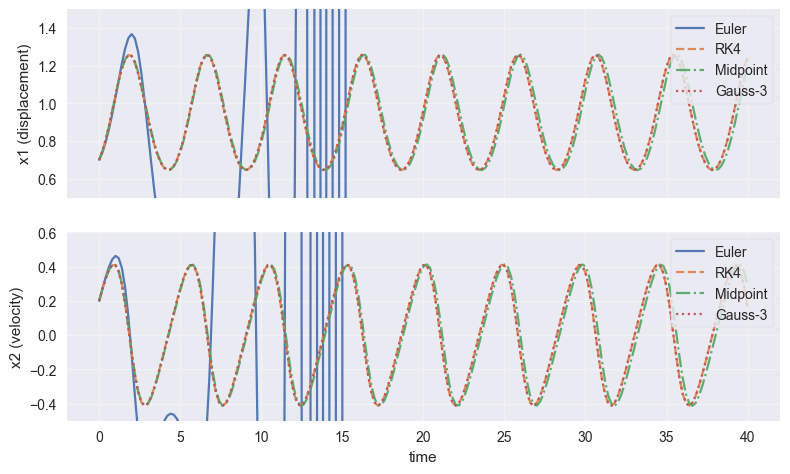

In [176]:
# Multi-step comparison
total_time = 40.0
h = 0.2
n_steps = int(total_time / h)
times = np.linspace(0.0, n_steps * h, n_steps + 1)

# storage
e_x1s, e_x2s = [x10], [x20]
rk_x1s, rk_x2s = [x10], [x20]
mp_x1s, mp_x2s = [x10], [x20]
gl_x1s, gl_x2s = [x10], [x20]

# integrate
for k in range(n_steps):
    t = times[k]
    # Euler
    ex1, ex2 = Euler(e_x1s[-1], e_x2s[-1],
                     alpha, beta, gamma, delta, omega, h, t)
    e_x1s.append(ex1); e_x2s.append(ex2)

    # RK4
    rx1, rx2 = RK4(rk_x1s[-1], rk_x2s[-1],
                   alpha, beta, gamma, delta, omega, h, t)
    rk_x1s.append(rx1); rk_x2s.append(rx2)

    # Midpoint (implicit) - catch failures
    try:
        mx1, mx2 = midpoint(mp_x1s[-1], mp_x2s[-1],
                             alpha, beta, gamma, delta, omega, h, t)
    except Exception as exc:
        print(f"midpoint failed at step {k}, t={t}: {exc}")
        mx1, mx2 = mp_x1s[-1], mp_x2s[-1]
    mp_x1s.append(mx1); mp_x2s.append(mx2)

    # Gauss-3 (implicit) - catch failures
    try:
        gx1, gx2 = GL3stage(gl_x1s[-1], gl_x2s[-1],
                             alpha, beta, gamma, delta, omega, h, t)
    except Exception as exc:
        print(f"GL3stage failed at step {k}, t={t}: {exc}")
        gx1, gx2 = gl_x1s[-1], gl_x2s[-1]
    gl_x1s.append(gx1); gl_x2s.append(gx2)

# convert to arrays
e_x1s = np.array(e_x1s); e_x2s = np.array(e_x2s)
rk_x1s = np.array(rk_x1s); rk_x2s = np.array(rk_x2s)
mp_x1s = np.array(mp_x1s); mp_x2s = np.array(mp_x2s)
gl_x1s = np.array(gl_x1s); gl_x2s = np.array(gl_x2s)

# print final values
print(f"After {n_steps} steps (h={h}, T={total_time}):")
print(" Euler   final:", e_x1s[-1], e_x2s[-1])
print(" RK4     final:", rk_x1s[-1], rk_x2s[-1])
print(" Midpoint final:", mp_x1s[-1], mp_x2s[-1])
print(" Gauss-3 final:", gl_x1s[-1], gl_x2s[-1])

# plot
plt.style.use('seaborn-v0_8')  # require matplotlib with seaborn styles; 可换成 'seaborn-darkgrid'
palette = {
    'Euler': '#4C72B0',    # muted blue
    'RK4':   '#DD8452',    # warm orange
    'Midpoint': '#55A868', # green
    'Gauss-3': '#C44E52'   # red
}

fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True)

# displacement
axs[0].plot(times, e_x1s, label='Euler', color=palette['Euler'], linewidth=1.6, alpha=0.95)
axs[0].plot(times, rk_x1s, label='RK4', color=palette['RK4'], linewidth=1.6, linestyle='--', alpha=0.95)
axs[0].plot(times, mp_x1s, label='Midpoint', color=palette['Midpoint'], linewidth=1.6, linestyle='-.', alpha=0.95)
axs[0].plot(times, gl_x1s, label='Gauss-3', color=palette['Gauss-3'], linewidth=1.6, linestyle=':', alpha=0.95)
axs[0].set_ylabel('x1 (displacement)')
axs[0].legend(frameon=True, loc='upper right')
axs[0].grid(True, alpha=0.35)

# velocity
axs[1].plot(times, e_x2s, label='Euler', color=palette['Euler'], linewidth=1.6, alpha=0.95)
axs[1].plot(times, rk_x2s, label='RK4', color=palette['RK4'], linewidth=1.6, linestyle='--', alpha=0.95)
axs[1].plot(times, mp_x2s, label='Midpoint', color=palette['Midpoint'], linewidth=1.6, linestyle='-.', alpha=0.95)
axs[1].plot(times, gl_x2s, label='Gauss-3', color=palette['Gauss-3'], linewidth=1.6, linestyle=':', alpha=0.95)
axs[1].set_ylabel('x2 (velocity)')
axs[1].set_xlabel('time')
axs[1].legend(frameon=True, loc='upper right')
axs[1].grid(True, alpha=0.35)

plt.tight_layout()
# axs[0].set_ylim(-20, 20)
# axs[1].set_ylim(-30, 30)
axs[0].set_ylim(0.5, 1.5)
axs[1].set_ylim(-0.5, 0.6)
plt.show()

Initial energies: E0_e=-0.164975, E0_rk=-0.164975, E0_mp=-0.164975, E0_gl=-0.164975
Final energies:   E_e[-1]=nan, E_rk[-1]=-0.165137, E_mp[-1]=-0.164364, E_gl[-1]=-0.164975
Max abs relative change (|E/E0 - 1|): Euler=nan, RK4=9.922e-04, Midpoint=3.897e-03, GL3=1.613e-08
Final relative change (E/E0 - 1): Euler=nan, RK4=9.835e-04, Midpoint=-3.703e-03, GL3=-1.037e-08


C:\Windows\Temp\ipykernel_29484\1253679334.py:5: RuntimeWarning: overflow encountered in square
  return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4
C:\Windows\Temp\ipykernel_29484\1253679334.py:5: RuntimeWarning: invalid value encountered in add
  return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4
C:\Windows\Temp\ipykernel_29484\1253679334.py:5: RuntimeWarning: overflow encountered in power
  return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4


(-0.01, 0.005)

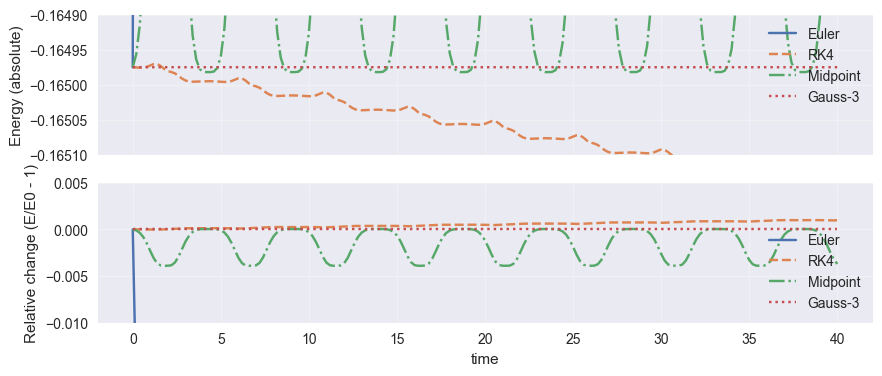

In [179]:
# let's set gamma and sigma as zero, to make the system hamiltonian
# gamma, delta = 0, 0

def energy(x, v, alpha, beta):
    return 0.5 * v**2 + 0.5 * alpha * x**2 + 0.25 * beta * x**4

E_e  = energy(e_x1s, e_x2s, alpha, beta)
E_rk = energy(rk_x1s, rk_x2s, alpha, beta)
E_mp = energy(mp_x1s, mp_x2s, alpha, beta)
E_gl = energy(gl_x1s, gl_x2s, alpha, beta)

# 相对误差（相对于初始能量）
E0_e  = E_e[0]  if E_e[0]  != 0 else 1.0
E0_rk = E_rk[0] if E_rk[0] != 0 else 1.0
E0_mp = E_mp[0] if E_mp[0] != 0 else 1.0
E0_gl = E_gl[0] if E_gl[0] != 0 else 1.0

rel_e  = (E_e  / E0_e) - 1.0  # equivalent to (E - E0) / E0
rel_rk = (E_rk / E0_rk) - 1.0
rel_mp = (E_mp / E0_mp) - 1.0
rel_gl = (E_gl / E0_gl) - 1.0

print(f"Initial energies: E0_e={E0_e:.6g}, E0_rk={E0_rk:.6g}, E0_mp={E0_mp:.6g}, E0_gl={E0_gl:.6g}")
print(f"Final energies:   E_e[-1]={E_e[-1]:.6g}, E_rk[-1]={E_rk[-1]:.6g}, E_mp[-1]={E_mp[-1]:.6g}, E_gl[-1]={E_gl[-1]:.6g}")
print("Max abs relative change (|E/E0 - 1|):",
      f"Euler={np.max(np.abs(rel_e)):.3e}, RK4={np.max(np.abs(rel_rk)):.3e}, Midpoint={np.max(np.abs(rel_mp)):.3e}, GL3={np.max(np.abs(rel_gl)):.3e}")
print("Final relative change (E/E0 - 1):",
      f"Euler={rel_e[-1]:.3e}, RK4={rel_rk[-1]:.3e}, Midpoint={rel_mp[-1]:.3e}, GL3={rel_gl[-1]:.3e}")


fig, axs = plt.subplots(2, 1, figsize=(10,4), sharex=True)
axs[0].plot(times, E_e,  label='Euler',   color=palette['Euler'])
axs[0].plot(times, E_rk, label='RK4',     color=palette['RK4'], linestyle='--')
axs[0].plot(times, E_mp, label='Midpoint',color=palette['Midpoint'], linestyle='-.')
axs[0].plot(times, E_gl, label='Gauss-3', color=palette['Gauss-3'], linestyle=':')
axs[0].set_ylabel('Energy (absolute)')
axs[0].legend(loc='upper right'); axs[0].grid(True, alpha=0.3)

axs[1].plot(times, rel_e,  label='Euler',   color=palette['Euler'])
axs[1].plot(times, rel_rk, label='RK4',     color=palette['RK4'], linestyle='--')
axs[1].plot(times, rel_mp, label='Midpoint',color=palette['Midpoint'], linestyle='-.')
axs[1].plot(times, rel_gl, label='Gauss-3', color=palette['Gauss-3'], linestyle=':')
axs[1].set_ylabel('Relative change (E/E0 - 1)')
axs[1].set_xlabel('time')
axs[1].grid(True, alpha=0.3)
axs[1].legend(loc='lower right')

# axs[0].set_ylim(-0.1656, -0.164)
axs[0].set_ylim(-0.1651, -0.1649)
axs[1].set_ylim(-0.01, 0.005)


PSD peak freq = 0.209948 Hz  (omega = 1.31914)
Fit: amplitude=2.31718e-13, phase=-1.7608 rad, offset=1.67811e-13, R^2=0.503659


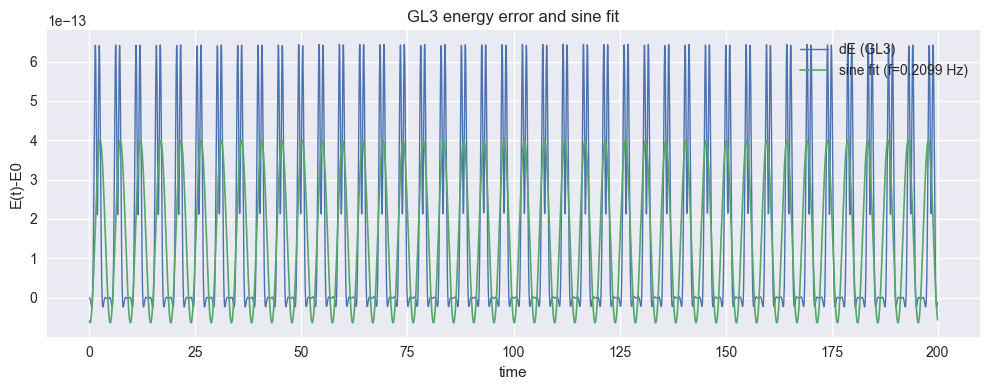

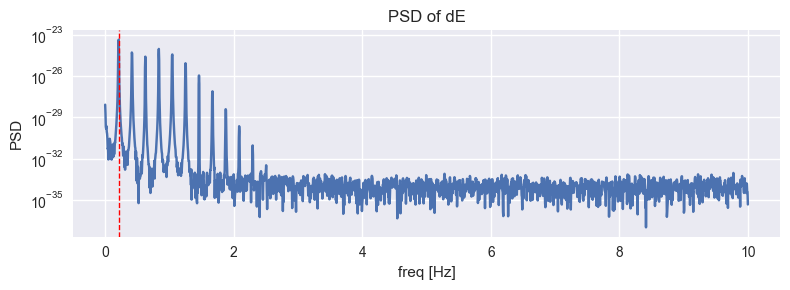

residual std = 1.627e-13, residual RMS / amp = 7.020e-01


In [181]:
# ...existing code...
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

def energy_series(method, x0, t0, h, T, params):
    n = int(np.ceil(T / h))
    x1, x2 = x0
    t = t0
    Es = np.empty(n+1)
    ts = np.linspace(t0, t0 + n*h, n+1)
    Es[0] = energy(x1, x2, params['alpha'], params['beta'])
    for k in range(n):
        x1, x2 = method(x1, x2, **params, h=h, time=t)
        t += h
        Es[k+1] = energy(x1, x2, params['alpha'], params['beta'])
    return ts, Es

# parameters (Hamiltonian case)
params = dict(alpha=alpha, beta=beta, gamma=0.0, delta=0.0, omega=omega)
x0 = (x10, x20)
t0 = 0.0
h = 0.05
T = 200.0

# compute GL3 energy series
ts, Es = energy_series(GL3stage, x0, t0, h, T, params)
dE = Es - Es[0]

# 1) PSD to find dominant frequency
fs = 1.0 / h
f, Pxx = welch(dE, fs=fs, nperseg=min(4096, len(dE)))
peak_idx = np.argmax(Pxx[1:]) + 1
f_peak = f[peak_idx]
omega_peak = 2 * np.pi * f_peak

# 2) fit model a*sin(ωt) + b*cos(ωt) + c using ω = 2π f_peak
sin_col = np.sin(omega_peak * ts)
cos_col = np.cos(omega_peak * ts)
A = np.column_stack([sin_col, cos_col, np.ones_like(ts)])
coef, *_ = np.linalg.lstsq(A, dE, rcond=None)
a, b, c0 = coef
amp = np.hypot(a, b)
phase = np.arctan2(b, a)            # dE ≈ amp * sin(ω t + phase) + c0
dE_fit = A @ coef
residual = dE - dE_fit
ss_res = np.sum(residual**2)
ss_tot = np.sum((dE - np.mean(dE))**2)
r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

# print summary
print(f"PSD peak freq = {f_peak:.6g} Hz  (omega = {omega_peak:.6g})")
print(f"Fit: amplitude={amp:.6g}, phase={phase:.6g} rad, offset={c0:.6g}, R^2={r2:.6g}")

# plots
plt.figure(figsize=(10,4))
plt.plot(ts, dE, label='dE (GL3)', linewidth=1)
plt.plot(ts, dE_fit, label=f'sine fit (f={f_peak:.4g} Hz)', linewidth=1.2, color='C1')
plt.xlabel('time'); plt.ylabel('E(t)-E0'); plt.legend(); plt.grid(True); plt.title('GL3 energy error and sine fit')
plt.tight_layout(); plt.show()

plt.figure(figsize=(8,3))
plt.semilogy(f, Pxx); plt.axvline(f_peak, color='r', lw=1, linestyle='--')
plt.xlabel('freq [Hz]'); plt.ylabel('PSD'); plt.title('PSD of dE'); plt.grid(True); plt.tight_layout(); plt.show()

# quick diagnostics: residual std and relative RMS
print(f"residual std = {np.std(residual):.3e}, residual RMS / amp = {np.sqrt(np.mean(residual**2))/ (amp if amp>0 else 1):.3e}")
# ...existing code...

10 201


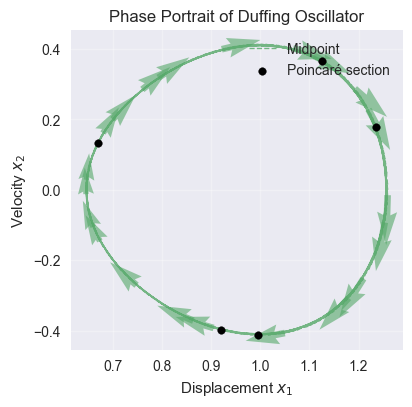

In [183]:
# 绘制相图 (Phase Portrait): velocity vs displacement
fig = plt.figure(figsize=(4,4))

# 1. 绘制轨迹
# plt.plot(rk_x1s, rk_x2s, label='RK4', color='#DD8452', linewidth=1)
plt.plot(mp_x1s, mp_x2s, label='Midpoint', color='#55A868', linewidth=1, linestyle='--', alpha=0.8)
# 如果想看 Euler 方法的偏差，可以取消下面这行的注释
# plt.plot(e_x1s, e_x2s, label='Euler', color='#4C72B0', linewidth=0.8, alpha=0.4)
# plt.plot(gl_x1s, gl_x2s, label='GL', color='#C44E52', linewidth=0.8, alpha=0.4)

# 2. 添加方向箭头 (Quiver plot)
# 为了不让箭头太密集，我们每隔一定步数采样一次
skip = max(1, int(len(rk_x1s)//20)) 
print(skip, len(rk_x1s))
# plt.quiver(rk_x1s[::skip], rk_x2s[::skip], 
#            np.gradient(rk_x1s)[::skip], np.gradient(rk_x2s)[::skip],
#            angles='xy', scale_units='xy', scale=1, width=0.02, color='#DD8452', alpha=0.6)
# plt.quiver(gl_x1s[::skip], gl_x2s[::skip], 
#            np.gradient(gl_x1s)[::skip], np.gradient(gl_x2s)[::skip],
#            angles='xy', scale_units='xy', scale=1, width=0.02, color='#C44E52', alpha=0.6)
plt.quiver(mp_x1s[::skip], mp_x2s[::skip], 
           np.gradient(mp_x1s)[::skip], np.gradient(mp_x2s)[::skip],
           angles='xy', scale_units='xy', scale=1, width=0.02, color='#55A868', alpha=0.6)


period = 2*np.pi/omega
idxs = [np.searchsorted(times, k*period) for k in range(1, int(times[-1]/period))]
plt.scatter(rk_x1s[idxs], rk_x2s[idxs], s=30, c='black', marker='o', zorder=5, label='Poincaré section')

plt.xlabel('Displacement $x_1$')
plt.ylabel('Velocity $x_2$')
plt.title('Phase Portrait of Duffing Oscillator')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# 4. 布局设置 (避免 LinAlgError)
# 显式设置边距，不使用 tight_layout
plt.subplots_adjust(left=0.12, right=0.95, top=0.92, bottom=0.12)

# 安全显示
try:
    plt.show()
finally:
    plt.close(fig)

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

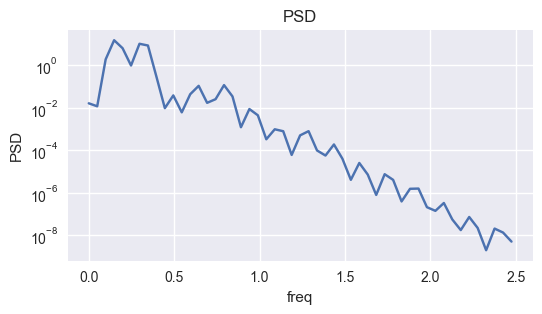

<Figure size 600x300 with 0 Axes>

In [24]:
# ...existing code...
# --- 简单时间序列分析：PSD、ACF、delay-embedding、Poincaré ---
from scipy.signal import welch
from statsmodels.tsa.stattools import acf

x = rk_x1s   # 选一个方法的位移时间序列（Euler/RK4/Midpoint/Gl3）
fs = 1.0 / h

# 1) PSD (Welch)
f, Pxx = welch(x, fs=fs, nperseg=min(1024, len(x)))
plt.figure(figsize=(6,3)); plt.semilogy(f, Pxx); plt.xlabel('freq'); plt.ylabel('PSD'); plt.grid(True); plt.title('PSD')

# 2) 自相关
lags = 200
ac = acf(x, nlags=lags, fft=True)
plt.figure(figsize=(6,3)); plt.stem(np.arange(len(ac)), ac, use_line_collection=True); plt.xlabel('lag'); plt.ylabel('ACF'); plt.title('Autocorrelation')

# 3) 延迟嵌入（Takens）
tau = int(0.1 / h) if h < 0.1 else 1
m = 3
Xembed = np.column_stack([x[i:len(x)- (m-1)*tau + i*0] if False else x[i*tau:len(x)-(m-1-i)*tau] for i in range(m)])  # 简单构造
plt.figure(figsize=(4,4)); plt.scatter(Xembed[-1000:,0], Xembed[-1000:,1], s=1); plt.xlabel('x(t)'); plt.ylabel(f'x(t+{tau}h)'); plt.title('Delay embedding (m=3)')

# 4) Poincaré（驱动周期处取样）
period = 2*np.pi/omega
idxs = [np.searchsorted(times, k*period) for k in range(1, int(times[-1]/period))]
plt.figure(figsize=(4,4))
plt.scatter(rk_x1s[idxs], rk_x2s[idxs], s=6); plt.xlabel('x1'); plt.ylabel('x2'); plt.title('Poincaré section')

plt.show()
# ...existing code...

In [ ]:
# let's set gamma and sigma as zero, to make the system hamiltonian


x0 = 1.0 status: singular derivative at step 1 (df≈0) len: 2
  first 6 iter: [1.0, 0.0]
x0 = 0.1 status: max_iter reached len: 501
  first 6 iter: [0.1, -4.95, -2.3739898989898993, -0.9763790575685589, 0.023906665950920836, -20.902715447124383]
x0 = 0.01 status: max_iter reached len: 501
  first 6 iter: [0.01, -49.995, -24.987498999899987, -12.47373949414661, -6.196785536541681, -3.0177057738522723]


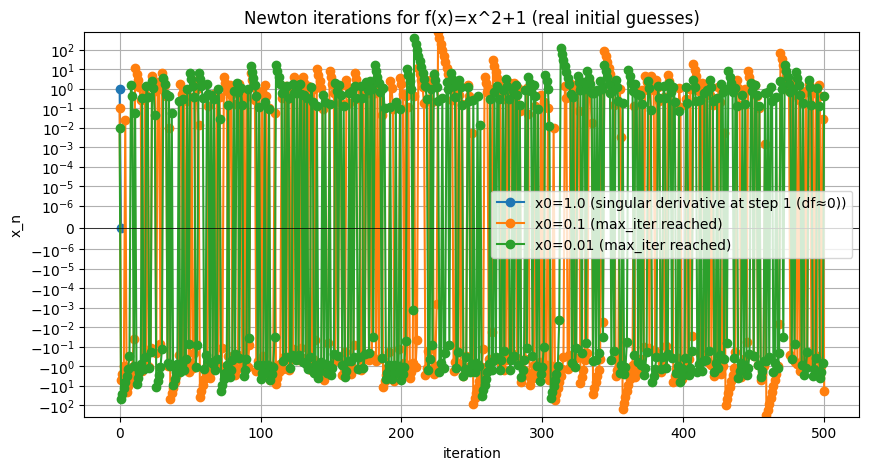

In [ ]:
# Test whether Newton's method fails
# E.g. Newton method to solve f(x)=x^2+1 (no real root) = 0 to show failure / divergence
# Note that f(x) does not have zeros
import math
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    # return x**2 + 1.0
    return 2.0 * x

def df(x):
    # return 2.0 * x
    return 2.0

def newton_iter(x0, max_iter=500, tol=1e-12, diverge_thresh=1e8):
    x = x0
    seq = [x]
    for k in range(max_iter):
        d = df(x)

        if abs(d) < 1e-14:
            return seq, "singular derivative at step %d (df≈0)" % k  # gradient vanishes
        
        x_new = x - f(x)/d
        seq.append(x_new)

        if math.isnan(x_new) or math.isinf(x_new) or abs(x_new) > diverge_thresh:
            return seq, "diverged at step %d" % (k+1)
        
        if abs(x_new - x) < tol:
            return seq, "converged in %d steps" % (k+1)
        
        x = x_new
    return seq, "max_iter reached"

# try several initial guesses
inits = [1.0, 0.1, 0.01]
# inits = [1.0, 0.1, 0.01, -0.1, 2.0, 0.001]
results = {}
for x0 in inits:
    seq, status = newton_iter(x0, max_iter=500)
    results[x0] = (seq, status)
    print("x0 =", x0, "status:", status, "len:", len(seq))
    print("  first 6 iter:", seq[:6])

# plot sequences (real part only)
plt.figure(figsize=(10,5))
for x0, (seq, status) in results.items():
    plt.plot(range(len(seq)), seq, marker='o', label=f"x0={x0} ({status})")
plt.axhline(0, color='k', linewidth=0.5)
plt.yscale('symlog', linthresh=1e-6)   # better view for large/small values
plt.xlabel("iteration")
plt.ylabel("x_n")
plt.title("Newton iterations for f(x)=x^2+1 (real initial guesses)")
plt.legend()
plt.grid(True)
plt.show()

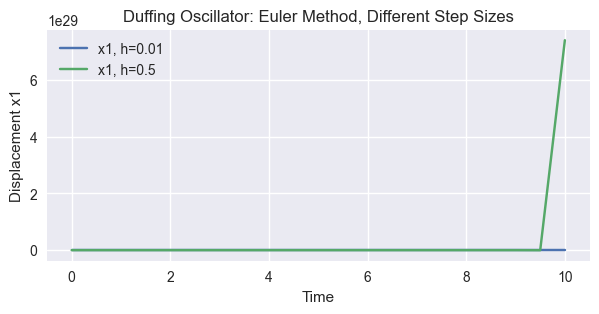

In [155]:
# Test whether Duffing equation is stiff
alpha, beta, gamma, delta, omega = -1.0, 1.0, 0.0, 0.0, 1.0
total_time = 10
time = 0

h_small = 0.01
h_large = 0.5

x1s_small_h = [0.7]
x2s_small_h = [0.2]

x1s_large_h = [0.7]
x2s_large_h = [0.2]

for step in range(int(total_time / h_small)):
    t = (step + 1) * h_small
    # x1, x2 = Euler(x1s_small_h[-1], x2s_small_h[-1], h=h_small, time=t)
    x1, x2 = Euler(x1s_small_h[-1], x2s_small_h[-1],
                    alpha, beta, gamma, delta, omega,
                    h=h_small, time=t)
    x1s_small_h.append(x1)
    x2s_small_h.append(x2)

for step in range(int(total_time / h_large)):
    t = (step + 1) * h_large
    # x1, x2 = Euler(x1s_large_h[-1], x2s_large_h[-1], h=h_large, time=t)
    x1, x2 = Euler(x1s_large_h[-1], x2s_large_h[-1],
                    alpha, beta, gamma, delta, omega,
                    h=h_large, time=t)
    x1s_large_h.append(x1)
    x2s_large_h.append(x2)

plt.figure(figsize=(7, 3))
plt.plot(np.arange(0, total_time + h_small, h_small), x1s_small_h, label='x1, h=0.01')
plt.plot(np.arange(0, total_time + h_large, h_large), x1s_large_h, label='x1, h=0.5')
plt.xlabel('Time')
plt.ylabel('Displacement x1')
plt.legend()
plt.title('Duffing Oscillator: Euler Method, Different Step Sizes')
plt.show()